<a href="https://colab.research.google.com/github/gianpDomiziani/TinyML/blob/main/GAN_cifar10_top.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolution Generative Adversial Network

In [1]:
import tensorflow as tf

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dfsr0jr7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-dfsr0jr7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0af7fffde9d304410f808c8752cfe519ba107ca33_-cp37-none-any.whl size=147328 sha256=19bb3416c1f7b7ea7e9857bc7f3d5c5f29ac5d8af4a10c585e304efa38772bb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-pgmsuiby/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from keras.preprocessing import image
from tensorflow.keras import initializers

# Download the CIFAR10 dataset
## select just class 6 (frog)
## reshape the images and normalise them


In [4]:
LATENT_DIM = 32
HEIGHT = 32
WIDTH = 32
CHANNELS = 3

In [39]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data() 

In [40]:
x_train = x_train[y_train.flatten() == 6]  # select class 6 (frogs)

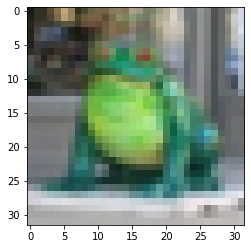

In [41]:
plt.imshow(x_train[1])

In [8]:
x_train = x_train.reshape(
  (x_train.shape[0],) + (HEIGHT, WIDTH, CHANNELS)
).astype('float32') / 255.

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
ngf = 64
ndf = 64

In [10]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# define the GENERATOR model
note that the GAN is trained without using bias, batchnormalization is used as
regularization, and the LeakyRelu instead of the Relu activation function is used, and the final activation function is a tanh, as suggests in the reference papers (see last cell)

In [56]:
def make_generator_model():
  generator_input = tf.keras.Input(shape=(LATENT_DIM,))

  x = layers.Dense(128 * 16 * 16, use_bias=False)(generator_input)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.ReLU()(x)
  x = layers.Reshape((16, 16, 128))(x)  # Transform the input into a 16x16x128 feature map

  # CONV NET (without Pooling Layers)
  x = layers.Conv2D(ngf*8, 2, strides=2, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.ReLU()(x)
  # input shape 4 x 4 x 512
  x = layers.Conv2DTranspose(ngf*4, 2, strides=2, use_bias=False, 
                             kernel_initializer=initializers.RandomNormal(stddev=0.02))(x) 
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.ReLU()(x)
  # input shape 8 x 8 x 256
  x = layers.Conv2D(ngf*2, 2, strides=2, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.ReLU()(x)
  # input shape 16 x 16 x 128
  x = layers.Conv2D(ngf, 2, strides=2, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.ReLU()(x)
  # input shape 32 x 32 x 3
  x = layers.Conv2D(CHANNELS, 7, use_bias=False, activation='tanh', padding='same')(x)
  generator = tf.keras.models.Model(generator_input, x)
  generator.summary()
  return generator


# Untrained generator produces unrecognizable images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1048576   
_________________________________________________________________
batch_normalization_25 (Batc (None, 32768)             131072    
_________________________________________________________________
re_lu_21 (ReLU)              (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 512)         262144    
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 8, 512)         2048

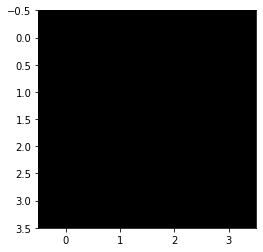

In [57]:
generator = make_generator_model()

noise = tf.random.normal((1,LATENT_DIM))
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

# Define DISCRIMINATOR model
dropout is used as regularization

In [13]:
def make_discriminator_model():
  discriminator_input = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
  # input 32 x 32 x 3
  x = layers.Conv2D(ndf, 4, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(discriminator_input)  
  # output 29 x 29 x 64
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(ndf*2, 4, padding='same', use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x) 
  # output 29 x 29 x 128
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(ndf*4, 4, strides=2, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  # output 13 x 13 x 256
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(ndf*8, 4, strides=2, use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.02))(x) 
  # output 5 x 5 x 512
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)

  x = layers.Dense(1, activation='sigmoid', use_bias=False)(x)
  discriminator = tf.keras.models.Model(discriminator_input, x)
  discriminator.summary()
  return discriminator

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       131072    
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 256)       5242

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.5)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 70
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    img_shape = images.shape
    noise = tf.random.normal([img_shape[0], LATENT_DIM])

    with tf.GradientTape() as disc_tape:
      # maximise E[D(x)]
      output = discriminator(images, training=True)
      real_label = tf.ones_like(output)
      D_r_loss = cross_entropy(real_label, output)
    grads_D_r = disc_tape.gradient(D_r_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads_D_r, discriminator.trainable_variables))

    with tf.GradientTape() as disc_tape:
      # maximise E[1 - D(x)]
      generated_images = generator(noise, training=True)
      output = discriminator(generated_images, training=True)
      fake_label = tf.zeros_like(output)
      D_f_loss = cross_entropy(fake_label, output)
    grads_D_f = disc_tape.gradient(D_f_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads_D_f, discriminator.trainable_variables))

    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape:
      # maximise E[D(G(x))]
      generated_images = generator(noise, training=True)
      output = discriminator(generated_images, training=True)
      real_label = tf.ones_like(output)
      G_loss = cross_entropy(real_label, output)
    grads_G = gen_tape.gradient(G_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads_G, generator.trainable_variables))

    return D_f_loss + D_r_loss, G_loss

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      disc_loss, gen_loss = train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f'gen loss: {gen_loss}')
    print(f'discr loss: {disc_loss}')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False) 

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

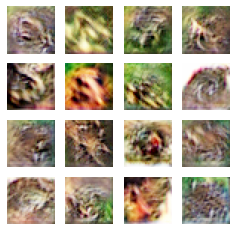

In [22]:
train(train_dataset, EPOCHS)

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [29]:
anim_file = f'dcgan_{time.time()}.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)